# Advanced Regularization in Natural Language Processing

## Regularization using a word2vec embedding

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import gensim.downloader
import nltk

# If running for the first time
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/vince/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
# Will take a while the first time, need to download about 1.6GB of the model
word2vec_model = gensim.downloader.load('word2vec-google-news-300')

In [4]:
!kaggle datasets download -d lakshmi25npathi/imdb-dataset-of-50k-movie-reviews --unzip

 93%|███████████████████████████████████▍  | 24.0M/25.7M [00:01<00:00, 36.5MB/s]
100%|██████████████████████████████████████| 25.7M/25.7M [00:01<00:00, 23.8MB/s]


In [3]:
# Load data
data = pd.read_csv('IMDB Dataset.csv')
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [4]:
# Split data into train and test sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=0)

In [5]:
# Define dataset class
class TextClassificationDataset(Dataset):
    def __init__(self, data, word2vec_model, max_words):
        self.data = data
        self.word2vec_model = word2vec_model
        self.max_words = max_words
        self.embeddings = data['review'].apply(self.embed)
        le = LabelEncoder()
        self.labels = torch.tensor(le.fit_transform(data['sentiment']).astype(np.float32))

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        return self.embeddings.iloc[index], self.labels[index]
    
    def embed(self, text):
        tokens = nltk.word_tokenize(text)
        return self.tokens_to_embeddings(tokens)
    
    def tokens_to_embeddings(self, tokens):
        embeddings = []
        for i, token in enumerate(tokens):
            if i >= self.max_words:
                break
            if token not in self.word2vec_model:
                continue
            embeddings.append(self.word2vec_model[token])

        while len(embeddings) < self.max_words:
            embeddings.append(np.zeros((300, )))
        
        return np.array(embeddings, dtype=np.float32)

In [8]:
batch_size = 64
max_words = 64

# Initialize datasets and dataloaders
train_dataset = TextClassificationDataset(train_data, word2vec_model, max_words)
test_dataset = TextClassificationDataset(test_data, word2vec_model, max_words)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [9]:
# Define RNN model
class GRUClassifier(nn.Module):
    def __init__(self, embedding_dim, hidden_size, output_size, num_layers=3):
        super(GRUClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size=embedding_dim, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, inputs):
        batch_size = inputs.size(0)
        zero_hidden = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
        output, hidden = self.gru(inputs, zero_hidden)
        output = torch.sigmoid(self.fc(output[:, -1]))
        return output

In [10]:
embedding_dim = 300
hidden_dim = 32
output_size = 1

# Optionally, set the device to GPU if you have one
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = GRUClassifier(
    embedding_dim=embedding_dim,
    hidden_size=hidden_dim, 
    output_size=output_size,
).to(device)

random_data = torch.rand((batch_size, max_words, embedding_dim)).to(device)
print(random_data.shape)
result = model(random_data)
print('Resulting output tensor:', result.shape)
print('Sum of the output tensor:', result.sum())

torch.Size([64, 64, 300])
Resulting output tensor: torch.Size([64, 1])
Sum of the output tensor: tensor(33.9811, device='cuda:0', grad_fn=<SumBackward0>)


In [11]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()

In [ ]:
def train_model(model, train_dataloader, test_dataloader, criterion, optimizer, device, epochs: int = 20):
    # Train the model
    train_losses = []
    test_losses = []
    train_accuracy = []
    test_accuracy = []

    for epoch in range(20):
        running_train_loss = 0.
        correct = 0.
        model.train()
        for inputs, labels in train_dataloader:
            inputs = inputs.to(device)
            labels = labels.unsqueeze(1).to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # Add correct predictions for this batch
            correct += ((outputs > 0.5) == labels).float().sum()
            # Compute loss for this batch
            running_train_loss += loss.item()

        # Compute and store loss and accuracy for this epoch
        train_epoch_loss = running_train_loss / len(train_dataloader)
        train_losses.append(train_epoch_loss)
        train_epoch_accuracy = correct / len(train_dataset)
        train_accuracy.append(train_epoch_accuracy.cpu().numpy())

        ## Evaluate the model on the test set
        running_test_loss = 0.
        correct = 0.
        model.eval()
        with torch.no_grad():
            for i, data in enumerate(test_dataloader, 0):
                inputs, labels = data
                inputs = inputs.to(device)
                labels = labels.unsqueeze(1).to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_test_loss += loss.item()
                correct += ((outputs > 0.5) == labels).float().sum()

            test_epoch_loss = running_test_loss / len(test_dataloader)
            test_losses.append(test_epoch_loss)
            test_epoch_accuracy = correct / len(test_dataset)
            test_accuracy.append(test_epoch_accuracy.cpu().numpy())

        # Print stats
        print(f'[epoch {epoch + 1}] Training: loss={train_epoch_loss:.3f} accuracy={train_epoch_accuracy:.3f} |\
    \t Test: loss={test_epoch_loss:.3f} accuracy={test_epoch_accuracy:.3f}')
        
    return train_losses, test_losses, train_accuracy, test_accuracy

In [12]:
train_losses, test_losses, train_accuracy, test_accuracy = train_model(
    model, train_dataloader, test_dataloader, criterion, optimizer, device, epochs=20
)

[epoch 1] Training: loss=0.572 accuracy=0.674 |	 Test: loss=0.478 accuracy=0.770
[epoch 2] Training: loss=0.451 accuracy=0.783 |	 Test: loss=0.450 accuracy=0.783
[epoch 3] Training: loss=0.429 accuracy=0.796 |	 Test: loss=0.433 accuracy=0.797
[epoch 4] Training: loss=0.413 accuracy=0.806 |	 Test: loss=0.431 accuracy=0.797
[epoch 5] Training: loss=0.399 accuracy=0.813 |	 Test: loss=0.425 accuracy=0.801
[epoch 6] Training: loss=0.384 accuracy=0.823 |	 Test: loss=0.417 accuracy=0.804
[epoch 7] Training: loss=0.371 accuracy=0.829 |	 Test: loss=0.430 accuracy=0.807
[epoch 8] Training: loss=0.360 accuracy=0.835 |	 Test: loss=0.424 accuracy=0.805
[epoch 9] Training: loss=0.346 accuracy=0.844 |	 Test: loss=0.429 accuracy=0.804
[epoch 10] Training: loss=0.335 accuracy=0.850 |	 Test: loss=0.455 accuracy=0.802
[epoch 11] Training: loss=0.320 accuracy=0.859 |	 Test: loss=0.433 accuracy=0.803
[epoch 12] Training: loss=0.305 accuracy=0.867 |	 Test: loss=0.428 accuracy=0.803
[epoch 13] Training: loss

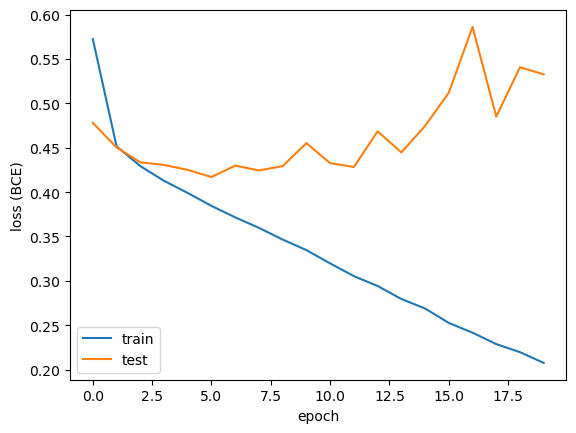

In [13]:
plt.plot(train_losses, label='train')
plt.plot(test_losses, label='test')
plt.xlabel('epoch')
plt.ylabel('loss (BCE)')
plt.legend()
plt.show()

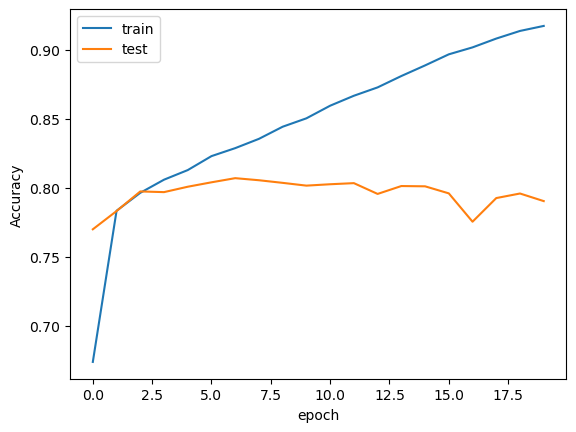

In [14]:
plt.plot(train_accuracy, label='train')
plt.plot(test_accuracy, label='test')
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Regularize with data augmentation using word2vec

In [1]:
import numpy as np
import gensim.downloader

In [2]:
# Load the Word2Vec model
word2vec_model = gensim.downloader.load('word2vec-google-news-300')

In [46]:
def replace_words_with_similar(text, model, sim_threshold: float = 0.5, probability: float = 0.5, top_similar: int = 3, stop_words: list[str] = []):
    # Split in words
    words = text.split()
    # Create an empty list of the output words
    new_words = []
    # Loop over the words
    for word in words:
        added = False
        # If the word is in the vocab, not in stop words, and above probability, then...
        if word in model and word not in stop_words and np.random.uniform(0, 1) > probability:
            # Get the top_similar most similar words 
            similar_words = model.most_similar(word, topn=top_similar)
            # Randomly pick one of those words
            idx = np.random.randint(len(similar_words))
            # Get the similar word and similarity score
            sim_word, sim_score = similar_words[idx]
            # If the similary score is above threshold, add the word
            if sim_score > sim_threshold:
                new_words.append(sim_word)
                added = True
        if not added:
            # If no similar word is added, add the original word
            new_words.append(word)
    # Return the list as a string
    return ' '.join(new_words)

In [52]:
original_text = "The quick brown fox jumps over the lazy dog"
generated_text = replace_words_with_similar(original_text, word2vec_model, stop_words=['the'])
print("Original text: {}".format(original_text))
print("New text: {}".format(generated_text))

Original text: The quick brown fox jumps over the lazy dog
New text: This quick brown squirrel jumps Over the lazy puppy


### There's more

In [ ]:
class TextClassificationDatasetGeneration(Dataset):
    def __init__(self, data, max_length):
        self.data = data
        self.max_length = max_length
        self.tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
        self.tokens = self.tokenizer(data['review'].to_list(), padding=True, truncation=True, max_length=max_length, return_tensors='pt')['input_ids']
        le = LabelEncoder()
        self.labels = torch.tensor(le.fit_transform(data['sentiment']).astype(np.float32))

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        # Generate a new text
        text = replace_words_with_similar(self.data['review'].iloc[index])
        # Tokenize it
        tokens = self.tokenizer(text, padding=True, truncation=True, max_length=self.max_length, return_tensors='pt')['input_ids']
        return self.tokens[index], self.labels[index]

## Zero-shot inference with pre-trained models

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from transformers import pipeline

In [2]:
!kaggle datasets download -d crowdflower/twitter-airline-sentiment --unzip

100%|██████████████████████████████████████| 2.55M/2.55M [00:00<00:00, 5.54MB/s]
100%|██████████████████████████████████████| 2.55M/2.55M [00:00<00:00, 4.73MB/s]


In [3]:
# Load data
data = pd.read_csv('Tweets.csv')
data[['airline_sentiment', 'text']].head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


In [4]:
# Split data into train and test sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=0)

In [5]:
# Taking a long time the first time for downloading model...
classifier = pipeline(task="zero-shot-classification", model="facebook/bart-large-mnli")

In [6]:
candidate_labels = data['airline_sentiment'].unique()
candidate_labels

array(['neutral', 'positive', 'negative'], dtype=object)

In [10]:
# Create an empty list to store the predictions
preds = []
# Loop over the data
for i in range(len(test_data)):
    # Compute the classifier results
    res = classifier(
        test_data['text'].iloc[i],
        candidate_labels=candidate_labels,
    )
    # Apply softmax to the results to get the predicted class
    pred = np.array(res['scores']).argmax()
    labels = res['labels']
    # Store the results in the list
    preds.append(labels[pred])

In [12]:
accuracy_score(test_data['airline_sentiment'], preds)

0.7452725250278087

### There's more

In [15]:
res = classifier(
    'I love to learn about regularization',
    candidate_labels=['positive', 'negative', 'neutral'],
)
res

{'sequence': 'I love to learn about regularization',
 'labels': ['positive', 'neutral', 'negative'],
 'scores': [0.6277033686637878, 0.27620458602905273, 0.09609206020832062]}

In [17]:
res['labels'][np.array(res['scores']).argmax()]

'positive'

## Regularization with BERT embeddings

In [1]:
import torch
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from transformers import BertConfig, BertModel, BertTokenizer
import pandas as pd

In [2]:
# Load data
data = pd.read_csv('Tweets.csv')
data.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [3]:
# Split data into train and test sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=0)

In [4]:
# Instantiate the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# Initializing a BERT configuration
configuration = BertConfig()
# Initializing a BERt model with random weights
bert = BertModel(configuration)
# Loading pre-trained weights
bert = bert.from_pretrained('bert-base-uncased')
# Load the model on the GPU if any
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bert.to(device)
# Set the model to eval mode
bert.eval()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

In [5]:
max_length = 24
# Compute the embeddings for the train set
train_tokens = tokenizer(train_data['text'].values.tolist(), add_special_tokens=True, padding='max_length', truncation=True, max_length=max_length, return_tensors='pt')
train_tokens = {k: v.to(device) for k, v in train_tokens.items()}
with torch.no_grad():
    train_embeddings = bert(**train_tokens).pooler_output
# Compute the embeddings for the test set
test_tokens = tokenizer(test_data['text'].values.tolist(), add_special_tokens=True, padding='max_length', truncation=True, max_length=max_length, return_tensors='pt')
test_tokens = {k: v.to(device) for k, v in test_tokens.items()}
with torch.no_grad():
    test_embeddings = bert(**test_tokens).pooler_output

In [ ]:
lr = LogisticRegression(C=0.5, max_iter=10000)
lr.fit(train_embeddings.cpu(), train_data['airline_sentiment'])

In [7]:
print('train accuracy:', lr.score(train_embeddings.cpu(), train_data['airline_sentiment']))
print('test accuracy:', lr.score(test_embeddings.cpu(), test_data['airline_sentiment']))

train accuracy: 0.8035348360655737
test accuracy: 0.7882513661202186


### There's more

In [16]:
tokens = tokenizer('What is a tokenizer?', add_special_tokens=True, padding='max_length', truncation=True, max_length=max_length, return_tensors='pt')
print(tokens)

{'input_ids': tensor([[  101,  2054,  2003,  1037, 19204, 17629,  1029,  2023,  2003,  1037,
          2204,  3160,  1012,   102,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])}


In [23]:
tokens = {k: v.to(device) for k, v in tokens.items()}
output = bert(**tokens)
print(output.pooler_output)

tensor([[-0.8947, -0.3769, -0.8185,  0.7429,  0.5408, -0.1211,  0.8675,  0.2659,
         -0.6507, -1.0000, -0.2761,  0.8524,  0.9738,  0.4190,  0.9171, -0.7309,
         -0.1398, -0.5986,  0.2661, -0.5249,  0.6231,  0.9999,  0.1622,  0.3898,
          0.3964,  0.9409, -0.7071,  0.9133,  0.9513,  0.7316, -0.6867,  0.1575,
         -0.9853, -0.1422, -0.7964, -0.9872,  0.3429, -0.6807,  0.0680,  0.0643,
         -0.8723,  0.2593,  0.9999, -0.5637,  0.3893, -0.3236, -1.0000,  0.2309,
         -0.8693,  0.8439,  0.8033,  0.7725,  0.1262,  0.4381,  0.4909, -0.2119,
         -0.1303,  0.1261, -0.2855, -0.5235, -0.6414,  0.3183, -0.6871, -0.8881,
          0.7282,  0.7444, -0.0875, -0.2863, -0.0955, -0.0733,  0.8767,  0.1984,
         -0.2358, -0.8437,  0.5129,  0.1521, -0.6840,  1.0000, -0.5588, -0.9722,
          0.7326,  0.7103,  0.6082, -0.2197,  0.4593, -1.0000,  0.5995,  0.0387,
         -0.9855,  0.1585,  0.5374, -0.2143,  0.6246,  0.6323, -0.5971, -0.4695,
         -0.3326, -0.6912, -

In [13]:
import openai
# Give your 
openai.api_key = 'xx-xxx'
# Query the API
input_text = 'This is a test sentence'
model = 'text-embedding-ada-002'
embeddings = openai.Embedding.create(input = [input_text], model=model)['data'][0]['embedding']

## Data augmentation using GPT-3

In [2]:
import openai

In [3]:
openai.api_key = 'xx-xxx'

In [5]:
positive_examples = openai.ChatCompletion.create(
    model="gpt-3.5-turbo",
    messages=[
        {"role": "system", "content": "You watched a movie you loved."},
        {"role": "user", "content": "Write a short, 100-words review about this movie"},
    ],
    max_tokens=128,
    temperature=0.5,
    n=3,
)

In [6]:
for i in range(len(positive_examples['choices'])):
    print(f'\n\nGenerated sentence {i+1}: \n')
    print(positive_examples['choices'][i]['message']['content'])



Generated sentence 1: 

I recently watched the movie "Inception" and was blown away by its intricate plot and stunning visuals. The film follows a team of skilled thieves who enter people's dreams to steal their secrets. The concept of dream-sharing is fascinating and the execution of the idea is flawless. The cast, led by Leonardo DiCaprio, delivers outstanding performances that add depth to the characters. The action scenes are thrilling and the special effects are mind-bending. The film's score by Hans Zimmer is also noteworthy, adding to the overall immersive experience. "Inception" is a masterpiece that will leave you pondering its themes long after the credits roll.


Generated sentence 2: 

I recently watched the movie "The Shawshank Redemption" and absolutely loved it. The story follows the life of a man named Andy Dufresne, who is wrongfully convicted of murder and sent to Shawshank prison. The movie beautifully portrays the struggles and hardships faced by prisoners, and th

In [4]:
# Generate the generated examples
negative_examples = openai.ChatCompletion.create(
    model="gpt-3.5-turbo",
    messages=[
        {"role": "system", "content": "You watched a movie you hated."},
        {"role": "user", "content": "Write a short, 100-words review about this movie"},
    ],
    max_tokens=128,
    temperature=0.5,
    n=3,
)
# Display the generated examples
for i in range(len(negative_examples['choices'])):
    print(f'\n\nGenerated sentence {i+1}: \n')
    print(negative_examples['choices'][i]['message']['content'])



Generated sentence 1: 

I recently watched a movie that left me feeling disappointed and frustrated. The plot was weak and predictable, and the characters were one-dimensional and unrelatable. The acting was subpar, with wooden performances and lackluster chemistry between the cast. The special effects were underwhelming and failed to add any excitement or visual interest to the film. Overall, I found myself checking the time and counting down the minutes until the end. I wouldn't recommend this movie to anyone looking for a compelling and engaging cinematic experience.


Generated sentence 2: 

I recently watched a movie that left me feeling disappointed and underwhelmed. The plot was predictable and lacked any real depth or complexity. The characters were one-dimensional and unrelatable, making it hard to invest in their stories. The pacing was slow and dragged on unnecessarily, making the already dull plot even more tedious to sit through. The acting was subpar, with even the most

### There's more

In [22]:
# Import the pipeline from transformers
from transformers import pipeline
# Instantiate a text-generation pipeline based on GPT-2 model
generator = pipeline('text-generation', model='gpt2')
#generator = pipeline('text2text-generation')#, model = 'facebook/mbart-large-50')

In [28]:
# Generate the positive examples
positive_example = generator(
    "I loved everything about this movie, ",
    max_length = 512,
    num_return_sequences=3,
)
# Display the generated examples
for i in range(len(positive_example)):
    print(f'\n\nGenerated sentence {i+1}: \n')
    print(positive_example[i]['generated_text'])



Generated sentence 1: 

I loved everything about this movie,  the movie itself was great and I didn't want to stop after the first movie because I was so happy for it. But I did like the first movie and I loved the second one and so much of what I did with it and other things with how I handled the other films.
What were your thoughts as fans?
After the opening credits, I kept thinking, "This will be my big, special moment, I can't do this alone". I've watched the original 2 episodes, they do have a big difference in the ending. But really, it's just my dream to put in movies you love, and I'm always looking over every minute on how good they were and looking forward.
I think because everyone is talking about it, and so much of the movie is just it of my dream, the movie that I am to get this, the movie that I want to watch or maybe I'm doing my dreams.
Also, it's more to a big than your dream. I think if I get enough reviews, people will start to see it. There will even be a few who